In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/Frames.zip'  # Update path if needed
extract_path = '/content/Frames'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Frames.zip extracted to:", extract_path)


✅ Frames.zip extracted to: /content/Frames


In [5]:
import os

base_path = '/content/Frames'
nested_folders = os.listdir(base_path)
print("🔍 Contents of /content/Frames:", nested_folders)

for folder in nested_folders:
    sub_path = os.path.join(base_path, folder)
    if os.path.isdir(sub_path):
        print(f"📁 {folder} ->", os.listdir(sub_path))


🔍 Contents of /content/Frames: ['Frames']
📁 Frames -> ['output 4', 'output_5', 'output 3']


In [7]:
import os

base_path = '/content/Frames/Frames'
folders = os.listdir(base_path)

print("📁 Checking folders inside:", base_path)

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        total_images += len([f for f in files if f.endswith('.jpg')])
    print(f"✅ {folder}: {total_images} .jpg images")


📁 Checking folders inside: /content/Frames/Frames
✅ output 4: 11498 .jpg images
✅ output_5: 12634 .jpg images
✅ output 3: 12098 .jpg images


In [8]:
import glob
import random

# Define the correct folder path
dataset_path = '/content/Frames/Frames'

# Map folder names to labels
label_map = {
    'output 3': 0,   # Low Stress
    'output 4': 1,   # Medium Stress
    'output_5': 2    # High Stress
}

# Gather all image paths and assign labels
image_paths = []
labels = []

for folder_name, label in label_map.items():
    folder_path = os.path.join(dataset_path, folder_name)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
                labels.append(label)

# Shuffle the dataset
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths[:], labels[:] = zip(*combined)

print("✅ Total images:", len(image_paths))
print("🧠 Example path & label:", image_paths[0], "→", labels[0])


✅ Total images: 36230
🧠 Example path & label: /content/Frames/Frames/output_5/frame_01147.jpg → 2


In [9]:
from sklearn.model_selection import train_test_split

# First split: train vs (val + test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.30, stratify=labels, random_state=42)

# Second split: validation vs test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42)

print(f"✅ Training set: {len(train_paths)} images")
print(f"✅ Validation set: {len(val_paths)} images")
print(f"✅ Test set: {len(test_paths)} images")


✅ Training set: 25361 images
✅ Validation set: 5434 images
✅ Test set: 5435 images


In [11]:
import cv2
import numpy as np
from tqdm import tqdm

# Parameters
IMG_HEIGHT, IMG_WIDTH = 64, 64   # Resize dimensions
SEQUENCE_LENGTH = 10             # Number of frames per sequence

def build_sequences(image_paths, labels, sequence_length):
    X, y = [], []

    for i in tqdm(range(0, len(image_paths) - sequence_length, sequence_length)):
        sequence = image_paths[i:i+sequence_length]
        label_seq = labels[i:i+sequence_length]

        # Ensure same label in sequence (simplification)
        if all(label == label_seq[0] for label in label_seq):
            frames = []
            for path in sequence:
                img = cv2.imread(path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0  # Normalize
                frames.append(img)
            X.append(frames)
            y.append(label_seq[0])

    return np.array(X), np.array(y)


In [13]:
def build_sequences_by_class(image_paths, labels, sequence_length):
    from collections import defaultdict

    # Group paths by label
    label_to_paths = defaultdict(list)
    for path, label in zip(image_paths, labels):
        label_to_paths[label].append(path)

    X, y = [], []

    for label, paths in label_to_paths.items():
        # Sort paths (optional: helps keep visual order)
        paths.sort()
        for i in range(0, len(paths) - sequence_length, sequence_length):
            sequence = paths[i:i+sequence_length]
            frames = []
            for path in sequence:
                img = cv2.imread(path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                frames.append(img)
            X.append(frames)
            y.append(label)

    return np.array(X), np.array(y)


In [14]:
print("🔁 Rebuilding training sequences...")
X_train, y_train = build_sequences_by_class(train_paths, train_labels, SEQUENCE_LENGTH)

print("🔁 Rebuilding validation sequences...")
X_val, y_val = build_sequences_by_class(val_paths, val_labels, SEQUENCE_LENGTH)

print("🔁 Rebuilding test sequences...")
X_test, y_test = build_sequences_by_class(test_paths, test_labels, SEQUENCE_LENGTH)

print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_val shape:   {X_val.shape}, y_val shape:   {y_val.shape}")
print(f"✅ X_test shape:  {X_test.shape}, y_test shape:  {y_test.shape}")


🔁 Rebuilding training sequences...
🔁 Rebuilding validation sequences...
🔁 Rebuilding test sequences...
✅ X_train shape: (2534, 10, 64, 64, 3), y_train shape: (2534,)
✅ X_val shape:   (542, 10, 64, 64, 3), y_val shape:   (542,)
✅ X_test shape:  (542, 10, 64, 64, 3), y_test shape:  (542,)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization

# Build the CNN+LSTM model
model = Sequential()

# TimeDistributed CNN layers
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=(10, 64, 64, 3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

# Output layer (3 stress classes)
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 32, 32, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 16, 16, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 16384)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     4,210,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,230,915 (16.14 MB)

 Trainable params: 4,230,723 (16.14 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4341 - loss: 1.0865
Epoch 1: val_accuracy improved from -inf to 0.99631, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.4350 - loss: 1.0854 - val_accuracy: 0.9963 - val_loss: 0.7376
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5963 - loss: 0.8561
Epoch 2: val_accuracy improved from 0.99631 to 0.99815, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 585s 7s/step - accuracy: 0.5965 - loss: 0.8558 - val_accuracy: 0.9982 - val_loss: 0.6496
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6780 - loss: 0.7451
Epoch 3: val_accuracy did not improve from 0.99815
80/80 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - accuracy: 0.6783 - loss: 0.7449 - val_accuracy: 0.9982 - val_loss: 0.5768
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7278 - loss: 0.6829
Epoch 4: val_accuracy did not improve from 0.99815
80/80 ━━━━━━━━━━━━━━━━━━━━ 563s 7s/step - accuracy: 0.7279 - loss: 0.6829 - val_accuracy: 0.9982 - val_loss: 0.5218
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7510 - loss: 0.6376
Epoch 5: val_accuracy did not improve from 0.99815
80/80 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - accuracy: 0.7509 - loss: 0.6376 - val_accuracy: 0.9982 - val_loss: 0.4752
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7442 - loss: 0.6196
Epoch 6: val_accuracy did not improve from 0.99815


80/80 ━━━━━━━━━━━━━━━━━━━━ 574s 7s/step - accuracy: 0.7907 - loss: 0.5645 - val_accuracy: 1.0000 - val_loss: 0.3700
Epoch 9/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7979 - loss: 0.5343
Epoch 9: val_accuracy did not improve from 1.00000
80/80 ━━━━━━━━━━━━━━━━━━━━ 558s 7s/step - accuracy: 0.7979 - loss: 0.5343 - val_accuracy: 1.0000 - val_loss: 0.3466
Epoch 10/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7815 - loss: 0.5381
Epoch 10: val_accuracy did not improve from 1.00000
80/80 ━━━━━━━━━━━━━━━━━━━━ 553s 6s/step - accuracy: 0.7813 - loss: 0.5382 - val_accuracy: 1.0000 - val_loss: 0.3321
Epoch 11/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7907 - loss: 0.5054
Epoch 11: val_accuracy did not improve from 1.00000
80/80 ━━━━━━━━━━━━━━━━━━━━ 570s 7s/step - accuracy: 0.7907 - loss: 0.5053 - val_accuracy: 1.0000 - val_loss: 0.3030
Epoch 12/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7921 - loss: 0.4939
Epoch 12: val_accuracy did not improve from 1.

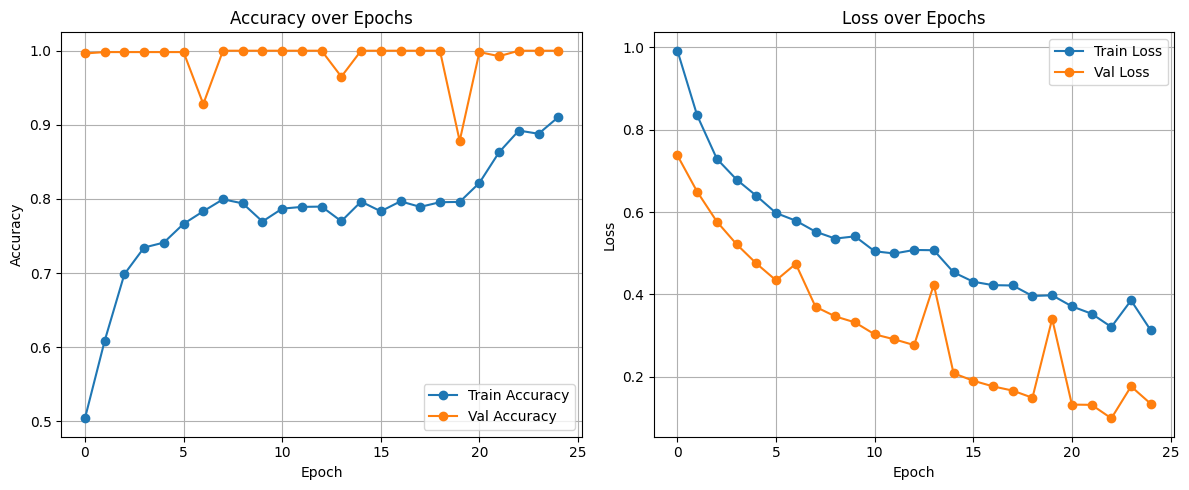

In [17]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 679ms/step
📊 Confusion Matrix:
[[181   0   0]
 [  0 172   0]
 [  0   0 189]]

📄 Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       181
      Medium       1.00      1.00      1.00       172
        High       1.00      1.00      1.00       189

    accuracy                           1.00       542
   macro avg       1.00      1.00      1.00       542
weighted avg       1.00      1.00      1.00       542



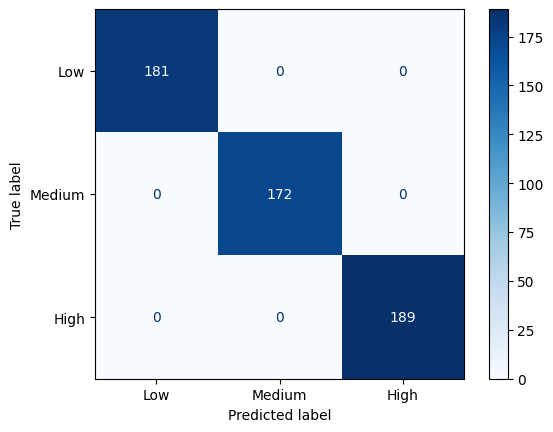

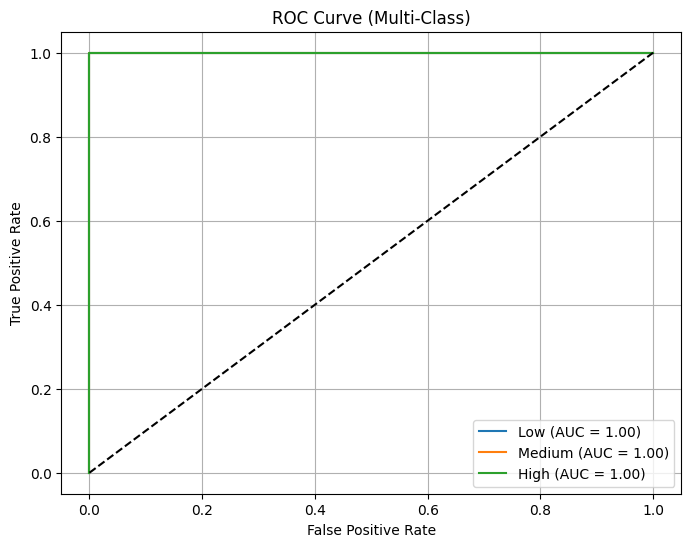

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("📊 Confusion Matrix:")
print(cm)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap='Blues')

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))

# ROC Curve (multi-class)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Low', 'Medium', 'High']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [19]:
# Class distribution
import pandas as pd
import numpy as np

def dataset_info(y, name):
    unique, counts = np.unique(y, return_counts=True)
    df = pd.DataFrame({"Label": unique, "Count": counts})
    df['Class'] = df['Label'].map({0: "Low", 1: "Medium", 2: "High"})
    print(f"📊 {name} Dataset Info:")
    print(df[['Class', 'Count']])
    print("-" * 40)

dataset_info(y_train, "Training")
dataset_info(y_val, "Validation")
dataset_info(y_test, "Test")


📊 Training Dataset Info:
    Class  Count
0     Low    846
1  Medium    804
2    High    884
----------------------------------------
📊 Validation Dataset Info:
    Class  Count
0     Low    181
1  Medium    172
2    High    189
----------------------------------------
📊 Test Dataset Info:
    Class  Count
0     Low    181
1  Medium    172
2    High    189
----------------------------------------


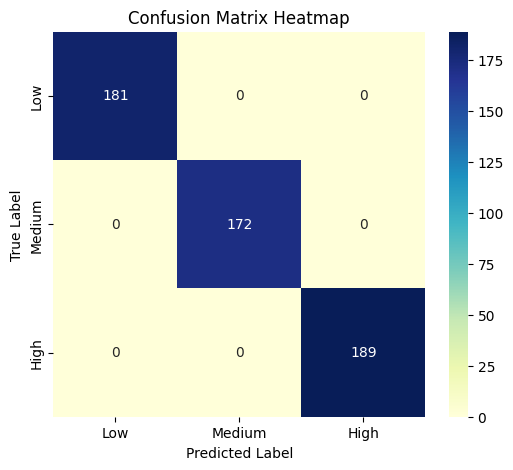

In [20]:
# Heatmap for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [21]:
# Save final model
model.save("stress_cnn_lstm_model.h5")
print("✅ Model saved as stress_cnn_lstm_model.h5")


✅ Model saved as stress_cnn_lstm_model.h5


In [22]:
# Save classification report to a .txt file
report = classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"])
with open("classification_report.txt", "w") as f:
    f.write(report)

print("📄 Classification report saved to classification_report.txt")


📄 Classification report saved to classification_report.txt


In [23]:
from google.colab import files
files.download('stress_cnn_lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>